<a href="https://colab.research.google.com/github/Chinmaya-3141/Capstone-Project/blob/Chinmaya/Capstone_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import numpy as np
from numba import cuda

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

In [ ]:
# Check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Set path here, access file path changes person to person

path = '/content/drive/MyDrive/Capstone Data (Shared)/Capstone Data/Resized Data/Resized Data_320x320'

In [ ]:
# Define the transform for the data

transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Load the data from the combined folder

data = ImageFolder(root=path, transform=transform)

In [ ]:
# Split the data into training and testing sets

train_data, test_data = torch.utils.data.random_split(data, [int(0.8*len(data)), len(data)-int(0.8*len(data))])

In [ ]:
# Define the data loaders

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Define the CNN model

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layer = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Hidden Layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            # Hidden Layer
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Hidden Layer
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc_layer = nn.Sequential(
            # Hidden Layer
            nn.Linear(128 * 20 * 20, 512),
            nn.ReLU(inplace=True),

            # Hidden Layer
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            # Output Layer
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [ ]:
from torchsummary import summary

In [ ]:
# Initialize the model

model = CNNModel().to(device)

In [ ]:
# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss()
# Sparse categorical cross entropy can also be used

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.9)
# Adam optimizer
# LBFGS optimizer

optimizer = optim.AdamW(model.parameters(),lr=0.001)
# optimizer = optim.AdamW(model.parameters(),lr=0.001)

In [ ]:
# Time the execution of the program
start_time = time.time()
loss_change = []

# Train the model
for epoch in range(20):
    running_loss = 0.0
    for i, datavar in enumerate(train_loader, 0):
        inputs, labels = datavar[0].to(device), datavar[1].to(device)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_change.append(float(running_loss))
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


# Synchronize all parallel processes
cuda.synchronize()

# Calculate time taken for each part of the parallel processing
end_time = time.time()
execution_time = end_time - start_time

In [ ]:
# Print summary of execution time

print(f"Total time: {int(execution_time/60)} minutes {execution_time - (int(execution_time/60)*60)} seconds")

Total time: 45 minutes 18.607905864715576 seconds


In [ ]:
import matplotlib.pyplot as plt

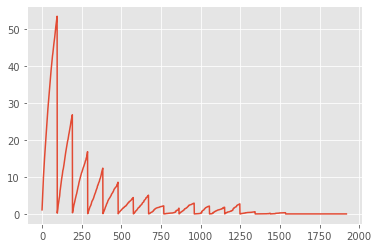

In [ ]:
plt.style.use("ggplot")
plt.plot(range(len(loss_change)),loss_change)
plt.show()

In [ ]:
# Evaluate the model on test data

correct = 0
total = 0
with torch.no_grad():
    for datavar in test_loader:
        images, labels = datavar
        images,labels = images.to(device),labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.datavar, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%'% (100 * correct / total))

Accuracy of the network on the test images: 96.216569 %


In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_layer.0.weight 	 torch.Size([16, 3, 3, 3])
conv_layer.0.bias 	 torch.Size([16])
conv_layer.3.weight 	 torch.Size([32, 16, 3, 3])
conv_layer.3.bias 	 torch.Size([32])
conv_layer.6.weight 	 torch.Size([64, 32, 3, 3])
conv_layer.6.bias 	 torch.Size([64])
conv_layer.9.weight 	 torch.Size([128, 64, 3, 3])
conv_layer.9.bias 	 torch.Size([128])
fc_layer.0.weight 	 torch.Size([512, 51200])
fc_layer.0.bias 	 torch.Size([512])
fc_layer.2.weight 	 torch.Size([256, 512])
fc_layer.2.bias 	 torch.Size([256])
fc_layer.4.weight 	 torch.Size([3, 256])
fc_layer.4.bias 	 torch.Size([3])


In [ ]:
# Print optimizer's state_dict
print("Optimizer's state_dict:\n")
for var_name in optimizer.state_dict():
    print(var_name, "\n", optimizer.state_dict()[var_name],"\n")

Optimizer's state_dict:

state 

 {0: {'step': tensor(1920.), 'exp_avg': tensor([[[[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]],

         [[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]],

         [[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]]],


        [[[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05]],

         [[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05]],

         [[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05

In [ ]:
# file = "AdamW-lr001-Batch64-15epochs.pth"
# torch.save(model.state_dict(),file)

In [ ]:
file="AdamW-lr001-Batch64-15epochs.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, file)

In [ ]:
checkpoint = torch.load(file)

In [ ]:
model2 = CNNModel().to(device)
optimizer2 = optim.Adam(model.parameters(),lr=0.001)

In [ ]:
# checkpoint = torch.load(file)
# model2.load_state_dict(checkpoint['model_state_dict'])
# optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint["epoch"]
# loss = checkpoint['loss']

In [ ]:
# Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model2.state_dict():
#     print(param_tensor, "\t", model2.state_dict()[param_tensor].size())

Model's state_dict:
conv_layer.0.weight 	 torch.Size([16, 3, 3, 3])
conv_layer.0.bias 	 torch.Size([16])
conv_layer.3.weight 	 torch.Size([32, 16, 3, 3])
conv_layer.3.bias 	 torch.Size([32])
conv_layer.6.weight 	 torch.Size([64, 32, 3, 3])
conv_layer.6.bias 	 torch.Size([64])
conv_layer.9.weight 	 torch.Size([128, 64, 3, 3])
conv_layer.9.bias 	 torch.Size([128])
fc_layer.0.weight 	 torch.Size([512, 51200])
fc_layer.0.bias 	 torch.Size([512])
fc_layer.2.weight 	 torch.Size([256, 512])
fc_layer.2.bias 	 torch.Size([256])
fc_layer.4.weight 	 torch.Size([3, 256])
fc_layer.4.bias 	 torch.Size([3])


In [ ]:
# Print optimizer's state_dict
# print("Optimizer's state_dict:\n")
# for var_name in optimizer2.state_dict():
#     print(var_name, "\n\n", optimizer2.state_dict()[var_name])

Optimizer's state_dict:

state 

 {0: {'step': tensor(1920.), 'exp_avg': tensor([[[[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]],

         [[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]],

         [[-7.3575e-06, -9.4751e-07,  4.2864e-06],
          [-1.0329e-05, -2.5403e-06,  3.7023e-06],
          [-1.4133e-05, -6.5502e-06,  6.0567e-07]]],


        [[[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05]],

         [[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05]],

         [[-1.7765e-05, -6.4728e-06,  1.0907e-05],
          [-4.4381e-05, -3.2131e-05, -9.9503e-06],
          [-6.4358e-05, -5.5500e-05, -3.5019e-05

In [ ]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images,labels = images.to(device),labels.to(device)
#         outputs = model2(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print('Accuracy of the network on the test images: %f %%'% (100 * correct / total))

Accuracy of the network on the test images: 96.216569 %


In [ ]:
# model = TheModelClass(*args, **kwargs)
# optimizer = TheOptimizerClass(*args, **kwargs)

# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()